In [ ]:
# pip install contractions
# Used for expanding contractions

Prepare Python Package

In [59]:
import numpy as np
import pandas as pd
from collections import Counter
import contractions

import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer

import pandas as pd

import random

import re

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Used for removing accented characters
import unicodedata

# pip install wordcloud
from wordcloud import WordCloud

import csv
from tqdm import tqdm

In [60]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yinruojiang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yinruojiang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yinruojiang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [61]:
def normalize_accented_chars(text):
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    return text

def expand_contractions(text):
    text = contractions.fix(text)
    return text

def preprocess_text(text, nor_acc:True, exp_con=True):
    if nor_acc:
        text = normalize_accented_chars(text)
    if exp_con:
        text = expand_contractions(text)
    return text

def tokenize_into_words(text):
    text = word_tokenize(text)
    return text

def remove_punctuation(text):
    text = [w for w in text if w.isalpha()]
    return text

def convert_to_lower_case(text):
    text = [w.lower() for w in text]
    return text

def remove_stop_words(text):
    stop_words = stopwords.words("english")
    text = [w for w in text if not w in stop_words]
    return text

def perform_stemming(text):
    stemmer = PorterStemmer()
    text = [stemmer.stem(w) for w in text]
    return text

def perform_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    return text

def clean_text(text, rem_pun:True, con_low=True, rem_sto=True, per_ste=False, per_lem=True):
    if rem_pun:
        text = remove_punctuation(text)
    if con_low:
        text = convert_to_lower_case(text)
    if rem_sto:
        text = remove_stop_words(text)
    if per_ste:
        text = perform_stemming(text)
    if per_lem:
        text = perform_lemmatization(text)
    return text

In [62]:
data = []

with open("booksummaries.txt", encoding="utf8") as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        data.append(row)
book_id = []
book_name = []
summary = []
genre = []

for i in tqdm(data):
    book_id.append(i[0])
    book_name.append(i[2])
    genre.append(i[5])
    summary.append(i[6])

df = pd.DataFrame({'book_id': book_id, 'book_name': book_name,
                       'genre': genre, 'summary': summary})

16559it [00:00, 39890.12it/s]
100%|███████████████████████████████████████████████████████████████████████| 16559/16559 [00:00<00:00, 1383673.27it/s]


In [63]:
df.drop(df[df['genre']==''].index, inplace=True)
df

,book_id,book_name,genre,summary
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
4,2080,A Fire Upon the Deep,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
5,2152,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge..."
...,...,...,...,...
16549,36372465,The Third Lynx,"{""/m/06n90"": ""Science Fiction""}",The story starts with former government agent...
16551,36534061,Remote Control,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction...",The series follows the character of Nick Ston...
16555,37054020,Transfer of Power,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,37122323,Decoded,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...


In [64]:
import json
json.loads(df['genre'][0]).values()
genres = []
for i in df['genre']:
    genres.append(list(json.loads(i).values()))
df['genre_new'] = genres
all_genres = sum(genres,[])
len(set(all_genres))

227

In [65]:
df["preprocessed_text"] = df["summary"].apply(lambda x: preprocess_text(x, nor_acc=False, exp_con=True))

df["tokenized_text"] = df["preprocessed_text"].apply(lambda x: tokenize_into_words(x))

df["cleaned_text"] = df["tokenized_text"].apply(lambda x: clean_text(x, rem_pun=True, con_low=True, rem_sto=True, per_ste=False, per_lem=True))

In [66]:
df["cleaned_text_length"] = df["cleaned_text"].apply(len)
df["cleaned_text_length"].describe()

count    12841.000000
mean       235.371778
std        265.070708
min          0.000000
25%         67.000000
50%        149.000000
75%        317.000000
max       4990.000000
Name: cleaned_text_length, dtype: float64

In [67]:
word_length = df["cleaned_text_length"].quantile(.9)
print(word_length)

533.0


In [68]:
df

,book_id,book_name,genre,summary,genre_new,preprocessed_text,tokenized_text,cleaned_text,cleaned_text_length
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...","[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca...","[Old, Major, ,, the, old, boar, on, the, Manor...","[old, major, old, boar, manor, farm, call, ani...",525
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...","[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan...","[Alex, ,, a, teenager, living, in, near-future...","[alex, teenager, living, england, lead, gang, ...",545
2,986,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...,"[The, text, of, The, Plague, is, divided, into...","[text, plague, divided, five, part, town, oran...",599
4,2080,A Fire Upon the Deep,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...,"[The, novel, posits, that, space, around, the,...","[novel, posit, space, around, milky, way, divi...",417
5,2152,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge...","[The, book, tells, the, story, of, Paul, Bäume...","[book, tell, story, paul, bäumer, german, sold...",368
...,...,...,...,...,...,...,...,...,...
16549,36372465,The Third Lynx,"{""/m/06n90"": ""Science Fiction""}",The story starts with former government agent...,[Science Fiction],The story starts with former government agent...,"[The, story, starts, with, former, government,...","[story, start, former, government, agent, fran...",85
16551,36534061,Remote Control,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction...",The series follows the character of Nick Ston...,"[Thriller, Fiction, Suspense]",The series follows the character of Nick Ston...,"[The, series, follows, the, character, of, Nic...","[series, follows, character, nick, stone, man,...",34
16555,37054020,Transfer of Power,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...,"[The, reader, first, meets, Rapp, while, he, i...","[reader, first, meet, rapp, covert, operation,...",114
16556,37122323,Decoded,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...,[Autobiography],The book follows very rough chronological ord...,"[The, book, follows, very, rough, chronologica...","[book, follows, rough, chronological, order, s...",139


In [69]:
df['tag_length'] = df["genre_new"].apply(lambda x:len(x))

In [70]:
df['tag_length'].describe()

count    12841.000000
mean         2.336578
std          1.401971
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: tag_length, dtype: float64

In [71]:
df

,book_id,book_name,genre,summary,genre_new,preprocessed_text,tokenized_text,cleaned_text,cleaned_text_length,tag_length
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...","[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca...","[Old, Major, ,, the, old, boar, on, the, Manor...","[old, major, old, boar, manor, farm, call, ani...",525,5
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...","[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan...","[Alex, ,, a, teenager, living, in, near-future...","[alex, teenager, living, england, lead, gang, ...",545,6
2,986,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...,"[The, text, of, The, Plague, is, divided, into...","[text, plague, divided, five, part, town, oran...",599,4
4,2080,A Fire Upon the Deep,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...,"[The, novel, posits, that, space, around, the,...","[novel, posit, space, around, milky, way, divi...",417,5
5,2152,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge...","[The, book, tells, the, story, of, Paul, Bäume...","[book, tell, story, paul, bäumer, german, sold...",368,2
...,...,...,...,...,...,...,...,...,...,...
16549,36372465,The Third Lynx,"{""/m/06n90"": ""Science Fiction""}",The story starts with former government agent...,[Science Fiction],The story starts with former government agent...,"[The, story, starts, with, former, government,...","[story, start, former, government, agent, fran...",85,1
16551,36534061,Remote Control,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction...",The series follows the character of Nick Ston...,"[Thriller, Fiction, Suspense]",The series follows the character of Nick Ston...,"[The, series, follows, the, character, of, Nic...","[series, follows, character, nick, stone, man,...",34,3
16555,37054020,Transfer of Power,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...,"[The, reader, first, meets, Rapp, while, he, i...","[reader, first, meet, rapp, covert, operation,...",114,2
16556,37122323,Decoded,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...,[Autobiography],The book follows very rough chronological ord...,"[The, book, follows, very, rough, chronologica...","[book, follows, rough, chronological, order, s...",139,1


C:\Users\yinruojiang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


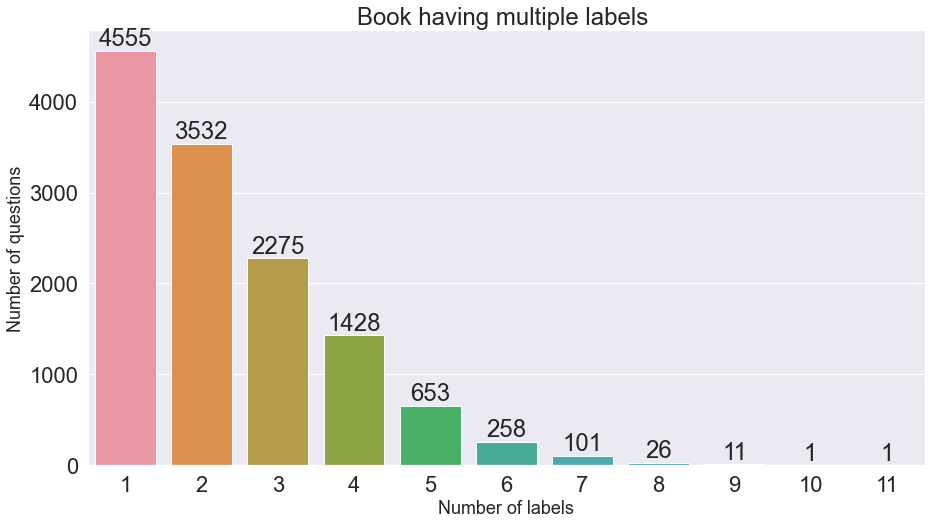

In [72]:
rowSums = df.iloc[:,9:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.sort_index().index, multiLabel_counts.sort_index().values)
plt.title("Book having multiple labels ")
plt.ylabel('Number of questions', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.sort_index().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.savefig('tags_distribution.png' , dpi = 250)
plt.show()

In [86]:
# Remove the multiple label rows which label number is above 5
removed_df = pd.DataFrame()
removed_df = df.drop(df[df.tag_length>3].index)
# print(removed_df.shape)
# removed_df

In [87]:
removed_df

,book_id,book_name,genre,summary,genre_new,preprocessed_text,tokenized_text,cleaned_text,cleaned_text_length,tag_length
5,2152,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge...","[The, book, tells, the, story, of, Paul, Bäume...","[book, tell, story, paul, bäumer, german, sold...",368,2
8,4081,Blade Runner 3: Replicant Night,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul...","[Science Fiction, Speculative fiction]","Living on Mars, Deckard is acting as a consul...","[Living, on, Mars, ,, Deckard, is, acting, as,...","[living, mar, deckard, acting, consultant, mov...",27,2
9,4082,Blade Runner 2: The Edge of Human,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...,"[Science Fiction, Speculative fiction]",Beginning several months after the events in ...,"[Beginning, several, months, after, the, event...","[beginning, several, month, event, blade, runn...",163,2
15,4386,Book of Job,"{""/m/02mdj1"": ""Religious text""}",The book of Job tells the story of an extreme...,[Religious text],The book of Job tells the story of an extreme...,"[The, book, of, Job, tells, the, story, of, an...","[book, job, tell, story, extremely, righteous,...",256,1
20,6020,Crash,"{""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf...",The story is told through the eyes of narrato...,"[Speculative fiction, Fiction, Novel]",The story is told through the eyes of narrato...,"[The, story, is, told, through, the, eyes, of,...","[story, told, eye, narrator, james, ballard, n...",55,3
...,...,...,...,...,...,...,...,...,...,...
16549,36372465,The Third Lynx,"{""/m/06n90"": ""Science Fiction""}",The story starts with former government agent...,[Science Fiction],The story starts with former government agent...,"[The, story, starts, with, former, government,...","[story, start, former, government, agent, fran...",85,1
16551,36534061,Remote Control,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction...",The series follows the character of Nick Ston...,"[Thriller, Fiction, Suspense]",The series follows the character of Nick Ston...,"[The, series, follows, the, character, of, Nic...","[series, follows, character, nick, stone, man,...",34,3
16555,37054020,Transfer of Power,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...,"[The, reader, first, meets, Rapp, while, he, i...","[reader, first, meet, rapp, covert, operation,...",114,2
16556,37122323,Decoded,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...,[Autobiography],The book follows very rough chronological ord...,"[The, book, follows, very, rough, chronologica...","[book, follows, rough, chronological, order, s...",139,1


The total number of tags is 194


C:\Users\yinruojiang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


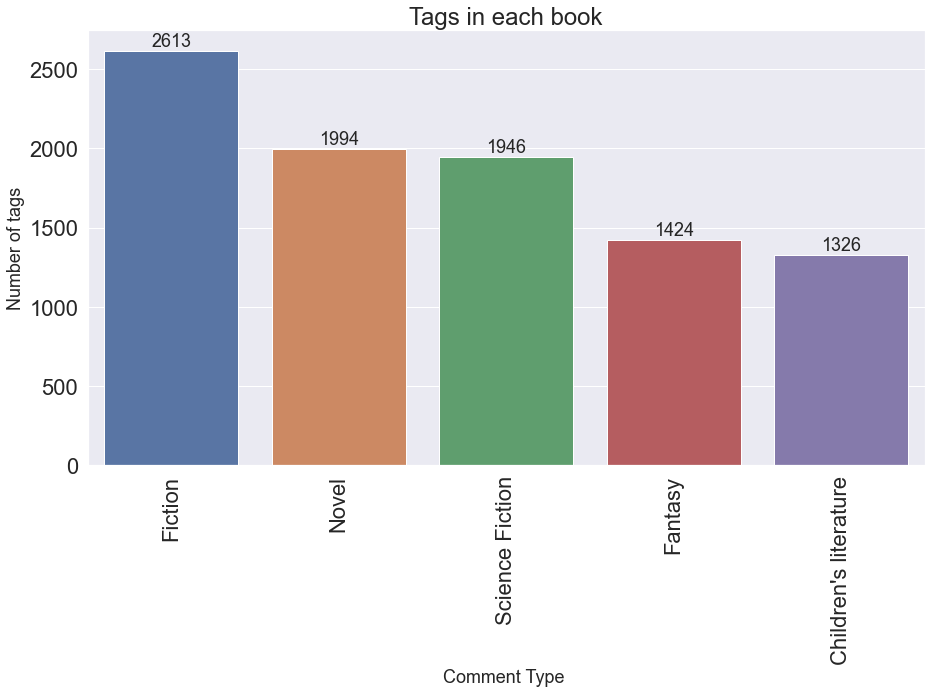

In [88]:
import collections
list_tags = []
removed_df['genre_new'].apply(lambda x:list_tags.extend(x))

counter=collections.Counter(list_tags)
print("The total number of tags is " + str(len(counter)))
tags = []
freqencies = []
for item in counter.most_common(6)[1:]:   
    tags.append(item[0])
    freqencies.append(item[1])

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(tags, freqencies)
plt.xticks(rotation='vertical')
plt.title("Tags in each book", fontsize=24)
plt.ylabel('Number of tags', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)
#adding the text labels
rects = ax.patches
labels = freqencies
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.savefig('tags.png' , dpi = 250)
plt.show()

In [89]:
# print(counter.most_common(20))
common_type = []
for item, count in counter.most_common(6):
    common_type.append(item)

def loop_common_type(origin_list,target_list):
    removed_list = []
    for item in origin_list:
        if item not in target_list:
            removed_list.append(item)
    cleaned_list = list(set(origin_list)-set(removed_list))
    return cleaned_list

In [90]:
removed_df['cleaned_genre'] = removed_df['genre_new'].apply(lambda x:loop_common_type(x,common_type))

In [91]:
removed_df

,book_id,book_name,genre,summary,genre_new,preprocessed_text,tokenized_text,cleaned_text,cleaned_text_length,tag_length,cleaned_genre
5,2152,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge...","[The, book, tells, the, story, of, Paul, Bäume...","[book, tell, story, paul, bäumer, german, sold...",368,2,[]
8,4081,Blade Runner 3: Replicant Night,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul...","[Science Fiction, Speculative fiction]","Living on Mars, Deckard is acting as a consul...","[Living, on, Mars, ,, Deckard, is, acting, as,...","[living, mar, deckard, acting, consultant, mov...",27,2,"[Science Fiction, Speculative fiction]"
9,4082,Blade Runner 2: The Edge of Human,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...,"[Science Fiction, Speculative fiction]",Beginning several months after the events in ...,"[Beginning, several, months, after, the, event...","[beginning, several, month, event, blade, runn...",163,2,"[Science Fiction, Speculative fiction]"
15,4386,Book of Job,"{""/m/02mdj1"": ""Religious text""}",The book of Job tells the story of an extreme...,[Religious text],The book of Job tells the story of an extreme...,"[The, book, of, Job, tells, the, story, of, an...","[book, job, tell, story, extremely, righteous,...",256,1,[]
20,6020,Crash,"{""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf...",The story is told through the eyes of narrato...,"[Speculative fiction, Fiction, Novel]",The story is told through the eyes of narrato...,"[The, story, is, told, through, the, eyes, of,...","[story, told, eye, narrator, james, ballard, n...",55,3,"[Novel, Speculative fiction, Fiction]"
...,...,...,...,...,...,...,...,...,...,...,...
16549,36372465,The Third Lynx,"{""/m/06n90"": ""Science Fiction""}",The story starts with former government agent...,[Science Fiction],The story starts with former government agent...,"[The, story, starts, with, former, government,...","[story, start, former, government, agent, fran...",85,1,[Science Fiction]
16551,36534061,Remote Control,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction...",The series follows the character of Nick Ston...,"[Thriller, Fiction, Suspense]",The series follows the character of Nick Ston...,"[The, series, follows, the, character, of, Nic...","[series, follows, character, nick, stone, man,...",34,3,[Fiction]
16555,37054020,Transfer of Power,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...,"[The, reader, first, meets, Rapp, while, he, i...","[reader, first, meet, rapp, covert, operation,...",114,2,[Fiction]
16556,37122323,Decoded,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...,[Autobiography],The book follows very rough chronological ord...,"[The, book, follows, very, rough, chronologica...","[book, follows, rough, chronological, order, s...",139,1,[]


In [105]:
new_df = removed_df[['book_name','cleaned_text','cleaned_text_length','cleaned_genre']]

In [106]:
new_df = new_df[new_df['cleaned_genre'].map(lambda x: len(x)) > 0]

In [108]:
new_df.to_csv('new_books_summary.csv')